<a href="https://colab.research.google.com/github/taimur1871/unet_deepdream/blob/main/Rana_bonus_week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Deep Dream to Visualize Regions of Interest

The workbook uses deep dream technique to identify the regions of interest detected by various layers in the unet model created to segment medical images. Specifically look at early and mid layers of the U-net are extracting features for in the Cirrus_3 and Nidek_1 data sets.

In [46]:
# import libraries
import tensorflow as tf

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [47]:
# change to directory containing the data and saved models
os.chdir('/content/drive/MyDrive/4BAI/Week 7')

## Setting up deep dream model

In [52]:
# image path
img_path_c3 = './Data/cirrus_3/test/Image/bscan_160.jpg'
img_path_ndk = './Data/nidek_1/test/Image/bscan_69.jpg'

# model path
model_path = '/content/drive/MyDrive/4BAI/Week 7/unet_1.h5'

In [49]:
# process image
def open_img(img_path, max_dim=None):
  img = PIL.Image.open(img_path)
  if max_dim:
    img = img.resize((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  #display.display(PIL.Image.fromarray(np.array(img)))
  if len(img.shape) == 3:
    plt.imshow(img[:,:,0], cmap='gray')
    plt.show()
  else:
    plt.imshow(img, cmap='gray')
    plt.show()

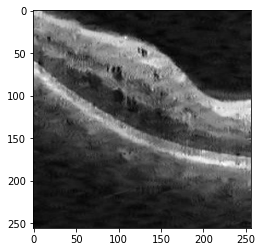

In [50]:
# display image
original_image = open_img(img_path_c3, max_dim=256)
show(original_image)

In [53]:
# import unet model for extracting features
base_model = tf.keras.models.load_model(model_path)
base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
_______________________________________________________________________________________

Since deep dream is based on maximizing activations of a layer we need to pick one of the conv layers. In this case we will use convolutions from 3rd layer of the unet model.

In [54]:
# get layer for deepdream model
layer_name = 'conv2d_20'
layer = base_model.get_layer(layer_name).output

In [72]:
# define deepdream model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layer)

In [73]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [74]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,1], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [75]:
deepdream = DeepDream(dream_model)

In [76]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = tf.convert_to_tensor(img/255., dtype=tf.float32)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

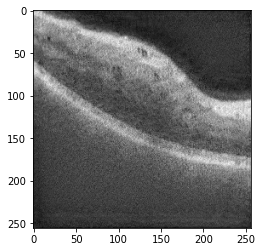

In [60]:
dream_img = run_deep_dream_simple(img=np.expand_dims(original_image, axis=2),
                                  steps=100, step_size=0.01)

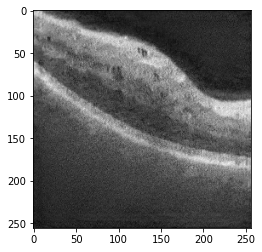

14.400224924087524

In [65]:
import time
start = time.time()

OCTAVE_SCALE = 1.50

img = octave_img
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 2):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = run_deep_dream_simple(img=np.expand_dims(original_image, axis=2),
                              steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

## Observations

The three images are shown below

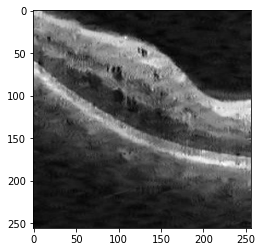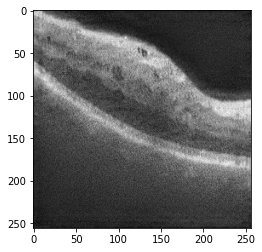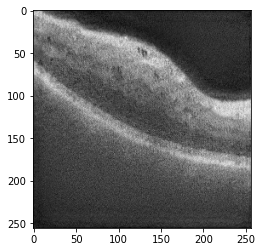

Based on these images it seems like that at this layer there is an activation to darker anomalies. This is a relatively shallow layer in the decoder so a lot more information is yet to be recompiled.

## Trying DeepDream on Nidek_1 Image

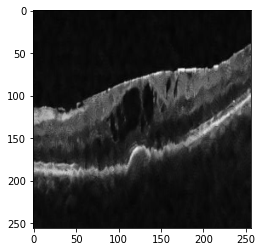

In [66]:
# display image
original_image = open_img(img_path_ndk, max_dim=256)
show(original_image)

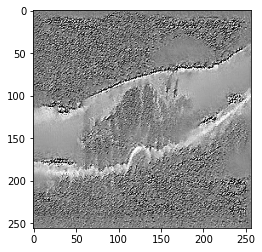

In [77]:
dream_img = run_deep_dream_simple(img=np.expand_dims(original_image, axis=2),
                                  steps=100, step_size=0.01)

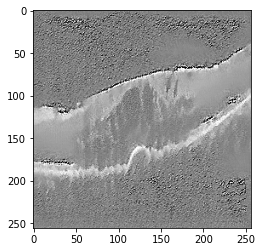

14.03803300857544

In [78]:
import time
start = time.time()

OCTAVE_SCALE = 1.50

img = octave_img
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 2):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = run_deep_dream_simple(img=np.expand_dims(original_image, axis=2),
                              steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

## Observations

The three images are shown below

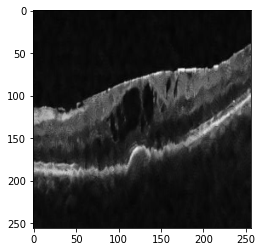
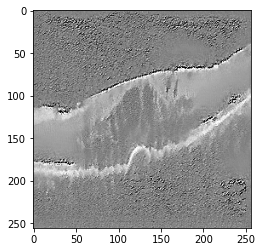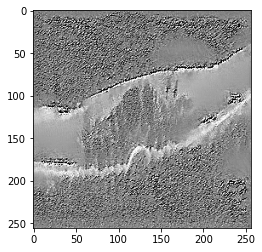

Based on these images it seems like that at this layer there is a very strong activation to darker more texturized surfaces. All the embossed areas appear as lighter smoother colors in the original image. The darker coarse surfaces have more variation in colors.

This is a fairly deep layer in the decoder so that may be the reason that image has more definition.


# Implement a shallower U-net

We will use depth 2 to report best results on Cirrus_3 and Nidek_1 data sets respectively. Shallower network implies fewer parameters. We will also compare outputs and metrics to see how these changes effect the model.

In [1]:
# Load libraries for the U-net Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import scipy.misc as sc

In [4]:
# change to directory containing the data and saved models
os.chdir('/content/drive/MyDrive/4BAI/Week 7')

In [5]:
#All additional functions for data prep and evaluation are housed in unet_helper_finctions.py
from unet_helper_functions import *

### Call to image data generator, model initialization, followed by model fitting.

In [6]:
#Step 1: Call to image data generator in keras
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='./Data/cirrus_3/train/'

In [7]:
if not os.path.exists(PATH+'shallow_aug'):
    os.makedirs(PATH+'shallow_aug')
    
if not os.path.exists('./Data/cirrus_3/test/'+'shallow_pred'):
    os.makedirs('./Data/cirrus_3/test/'+'shallow_pred')    
data_gen = trainGenerator(10,PATH,'Image','GT',data_gen_args, save_to_dir = PATH+'shallow_aug')

In [8]:
# Define the shallow U-net model
def unet_shallow(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)

    # first downsample layer
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # second downsample layer
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # final conv layers or lower layer of U
    conv3 = Conv2D(256, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.5)(conv3)
    
    
    # first up layer
    up4 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop3))
    merge4 = concatenate([drop2,up4], axis = 3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    # second up layer
    up5 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv1,up5], axis = 3)
    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    conv6 = Conv2D(1, 1, activation = 'sigmoid')(conv5)

    model = tf.keras.Model(inputs = inputs, outputs = conv6)

    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [9]:
#Step 2: Initialize the model. Train from scratch!
model = unet_shallow()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
# Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
# custom callback for stopping at a certain accuracy
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True

stop_train = mycallback()

In [12]:
# Fit the u-net shallow model
model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1, callbacks=[tensorboard_callback, stop_train])

Found 91 images belonging to 1 classes.
Found 91 images belonging to 1 classes.
Epoch 1/50
 1/15 [=>............................] - ETA: 0s - loss: 0.7742 - accuracy: 0.2522WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
15/15 [==============================] - 50s 3s/step - loss: 0.2657 - accuracy: 0.8734
Epoch 2/50
15/15 [==============================] - 6s 427ms/step - loss: 0.1066 - accuracy: 0.9566
Epoch 3/50
15/15 [==============================] - 7s 454ms/step - loss: 0.0776 - accuracy: 0.9691
Epoch 4/50
15/15 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9741
Reached 97% accuracy so cancelling training!
15/15 [==============================] - 7s 435ms/step - loss: 0.0685 - accuracy: 0.9741


In [13]:
model.save('unet_shallow_cirrus3.h5')

In [ ]:
# uncomment if you want to see the tensorboard logs
#%tensorboard --logdir logs/fit

## Run the trained model on test images and save the outputs, and evaluate pixel-level segmentation performance 

In [14]:
# Run model on test images and save the images
# number of test images
n_i=len(os.listdir('./Data/cirrus_3/test/Image/'))
# Call test generator
test_gen = testGenerator('./Data/cirrus_3/test/Image/')
# Return model outcome for each test image
results = model.predict_generator(test_gen,n_i,verbose=1)

saveResult('./Data/cirrus_3/test/Image/','./Data/cirrus_3/test/shallow_pred/',results)

Instructions for updating:
Please use Model.predict, which supports generators.
48/48 [==============================] - 14s 297ms/step


In [15]:
# Evaluate the predicted outcome
gt_path='./Data/cirrus_3/test/GT/'
evalResult(gt_path,results)

Precision= 0.00032096171802054155 Recall= 0.0005042170883755042 IoU= 0.00019798416126709864 acc= 0.9715061187744141 F1= 0.0003922407645129083


## Transfer learning on nidek_1 data and perform tests

I had originally tried to train a model on the data but given very small dataset the results were abysmal. So I am reverting back to training using transfer learning

### Get nidek_1 data

In [16]:
# create data pipelines
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='./Data/nidek_1/train/'

In [17]:
if not os.path.exists(PATH+'shallow_aug'):
    os.makedirs(PATH+'shallow_aug')
    
if not os.path.exists('./Data/nidek_1/test/'+'shallow_pred'):
    os.makedirs('./Data/nidek_1/test/'+'shallow_pred')    
data_gen = trainGenerator(10,PATH,'Image','GT',data_gen_args, save_to_dir = PATH+'shallow_aug')

## Original training using new model

left here for referrence

In [ ]:
# Initialize the model. Train from scratch!
#model = unet_shallow()
#model.summary()

In [ ]:
# Fit the u-net shallow model
#model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1, callbacks=[tensorboard_callback])

In [ ]:
#model.save('unet_shallow_nidek1.h5')

## Transfer Learning from Cirrus3 Model

In [18]:
# load_model
base_model = tf.keras.models.load_model('unet_shallow_cirrus3.h5')

In [19]:
# freeze layers of the model except last 3 layers
for layer in base_model.layers[:-3]:
  layer.trainable = False

In [20]:
# create the new model
model = tf.keras.Sequential([tf.keras.Input(shape=(256,256,1)), base_model])

In [21]:
# compile model
model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = 'accuracy')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 256, 256, 1)       1866373   
Total params: 1,866,373
Trainable params: 38,085
Non-trainable params: 1,828,288
_________________________________________________________________


In [23]:
model.fit(data_gen, steps_per_epoch=15,epochs=50,verbose=1, callbacks=[tensorboard_callback, stop_train])

Found 23 images belonging to 1 classes.
Found 23 images belonging to 1 classes.
Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.9775
Reached 97% accuracy so cancelling training!
15/15 [==============================] - 12s 817ms/step - loss: 0.1163 - accuracy: 0.9775


In [24]:
model.save('unet_shallow_nidek1.h5')

## Run the trained model on test images and save the outputs, and evaluate pixel-level segmentation performance 

In [25]:
# Run model on test images and save the images
# number of test images
n_i=len(os.listdir('./Data/nidek_1/test/Image/'))
# Call test generator
test_gen = testGenerator('./Data/nidek_1/test/Image/')
# Return model outcome for each test image
results = model.predict_generator(test_gen,n_i,verbose=1)

saveResult('./Data/nidek_1/test/Image/','./Data/nidek_1/test/shallow_pred/',results)

30/30 [==============================] - 9s 304ms/step


In [26]:
# Evaluate the predicted outcome
gt_path='./Data/nidek_1/test/GT/'
evalResult(gt_path,results)

Precision= 0.11335212626040034 Recall= 0.3161274167586614 IoU= 0.0798498401146624 acc= 0.9194295247395833 F1= 0.14623829351567064


# Training 3 layer unet

After the dissapointing performance on 2 layer unet also trying the 3 layer version.

In [27]:
#Step 1: Call to image data generator in keras
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='./Data/cirrus_3/train/'

In [28]:
if not os.path.exists(PATH+'shallow_aug'):
    os.makedirs(PATH+'shallow_aug')
    
if not os.path.exists('./Data/cirrus_3/test/'+'shallow_pred_3layer'):
    os.makedirs('./Data/cirrus_3/test/'+'shallow_pred_3layer')    
data_gen = trainGenerator(10,PATH,'Image','GT',data_gen_args, save_to_dir = PATH+'shallow_aug')

In [29]:
# Define the shallow U-net model
def unet_3layer(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)

    # first downsample layer
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # second downsample layer
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # third downsample layer
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    # final conv layers or lower layer of U
    conv4 = Conv2D(512, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    
    
    # first up layer
    up5 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge5 = concatenate([drop3,up5], axis = 3)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    
    # second up layer
    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    # third up layer
    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    conv8 = Conv2D(1, 1, activation = 'sigmoid')(conv7)

    model = tf.keras.Model(inputs = inputs, outputs = conv8)

    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [30]:
# Initialize the model. Train from scratch!
model = unet_3layer()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 256, 256, 64) 256         conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_6[0][0]      
_______________________________________________________________________________________

In [31]:
# Fit the u-net shallow model
model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1, callbacks=[tensorboard_callback, stop_train])

Found 91 images belonging to 1 classes.
Found 91 images belonging to 1 classes.
Epoch 1/50
 2/15 [===>..........................] - ETA: 5s - loss: 0.5534 - accuracy: 0.9576WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2157s vs `on_train_batch_end` time: 0.5115s). Check your callbacks.


15/15 [==============================] - 9s 620ms/step - loss: 0.2353 - accuracy: 0.9515
Epoch 2/50
15/15 [==============================] - 9s 597ms/step - loss: 0.0931 - accuracy: 0.9489
Epoch 3/50
15/15 [==============================] - 10s 643ms/step - loss: 0.0735 - accuracy: 0.9498
Epoch 4/50
15/15 [==============================] - 9s 621ms/step - loss: 0.0682 - accuracy: 0.9502
Epoch 5/50
15/15 [==============================] - 10s 663ms/step - loss: 0.0680 - accuracy: 0.9498
Epoch 6/50
15/15 [==============================] - 9s 619ms/step - loss: 0.0672 - accuracy: 0.9747
Epoch 7/50
15/15 [==============================] - 10s 646ms/step - loss: 0.0656 - accuracy: 0.9789
Epoch 8/50
15/15 [==============================] - 9s 604ms/step - loss: 0.0630 - accuracy: 0.9801
Epoch 9/50
15/15 [==============================] - 9s 632ms/step - loss: 0.0632 - accuracy: 0.9801
Epoch 10/50
15/15 [==============================] - 9s 602ms/step - loss: 0.0648 - accuracy: 0.9789
Epoch 1

In [32]:
model.save('unet_3layer_cirrus3.h5')

### Testing Model

In [33]:
# Run model on test images and save the images
# number of test images
n_i=len(os.listdir('./Data/cirrus_3/test/Image/'))
# Call test generator
test_gen = testGenerator('./Data/cirrus_3/test/Image/')
# Return model outcome for each test image
results = model.predict_generator(test_gen,n_i,verbose=1)

saveResult('./Data/cirrus_3/test/Image/','./Data/cirrus_3/test/shallow_pred_3layer/',results)

 1/48 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0086s vs `on_predict_batch_end` time: 0.0234s). Check your callbacks.


48/48 [==============================] - 1s 23ms/step


/content/drive/MyDrive/4BAI/Week 7/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/shallow_pred_3layer/bscan_154.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/drive/MyDrive/4BAI/Week 7/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/shallow_pred_3layer/bscan_151.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/drive/MyDrive/4BAI/Week 7/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/shallow_pred_3layer/bscan_163.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/drive/MyDrive/4BAI/Week 7/unet_helper_functions.py:119: UserWarning: ./Data/cirrus_3/test/shallow_pred_3layer/bscan_155.jpg_predict.png is a low contrast image
  io.imsave(os.path.join(save_path, files[i]+'_predict.png'),img)
/content/drive/MyDrive/4BAI/Week 7/unet_helper_functions.py:

In [34]:
# Evaluate the predicted outcome
gt_path='./Data/cirrus_3/test/GT/'
evalResult(gt_path,results)

/content/drive/MyDrive/4BAI/Week 7/unet_helper_functions.py:178: RuntimeWarning: invalid value encountered in true_divide
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
/content/drive/MyDrive/4BAI/Week 7/unet_helper_functions.py:178: RuntimeWarning: invalid value encountered in greater
  img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
/content/drive/MyDrive/4BAI/Week 7/unet_helper_functions.py:140: RuntimeWarning: invalid value encountered in double_scalars
  prec=tp/(tp+fp)


Precision= nan Recall= 0.2738930905914169 IoU= 0.175255704418092 acc= 0.993236223856608 F1= 0.2600560253749554


## Transfer Learning from Cirrus3 Model

In [35]:
# create data pipelines
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='./Data/nidek_1/train/'

In [36]:
if not os.path.exists(PATH+'shallow_aug'):
    os.makedirs(PATH+'shallow_aug')
    
if not os.path.exists('./Data/nidek_1/test/'+'shallow_pred_3layer'):
    os.makedirs('./Data/nidek_1/test/'+'shallow_pred_3layer')    
data_gen = trainGenerator(10,PATH,'Image','GT',data_gen_args, save_to_dir = PATH+'shallow_aug')

In [37]:
# load_model
base_model = tf.keras.models.load_model('unet_3layer_cirrus3.h5')

In [38]:
# freeze layers of the model except last 3 layers
for layer in base_model.layers[:-3]:
  layer.trainable = False

In [39]:
# create the new model
model = tf.keras.Sequential([tf.keras.Input(shape=(256,256,1)), base_model])

In [40]:
# compile model
model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = 'accuracy')

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 256, 256, 1)       7704965   
Total params: 7,704,965
Trainable params: 38,085
Non-trainable params: 7,666,880
_________________________________________________________________


In [42]:
model.fit(data_gen, steps_per_epoch=15,epochs=50,verbose=1, callbacks=[tensorboard_callback, stop_train])

Found 23 images belonging to 1 classes.
Found 23 images belonging to 1 classes.
Epoch 1/50
15/15 [==============================] - 5s 307ms/step - loss: 0.1018 - accuracy: 0.9488
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9765
Reached 97% accuracy so cancelling training!
15/15 [==============================] - 5s 301ms/step - loss: 0.0689 - accuracy: 0.9765


In [43]:
model.save('unet_3layer_nidek1.h5')

## Run the trained model on test images and save the outputs, and evaluate pixel-level segmentation performance 

In [44]:
# Run model on test images and save the images
# number of test images
n_i=len(os.listdir('./Data/nidek_1/test/Image/'))
# Call test generator
test_gen = testGenerator('./Data/nidek_1/test/Image/')
# Return model outcome for each test image
results = model.predict_generator(test_gen,n_i,verbose=1)

saveResult('./Data/nidek_1/test/Image/','./Data/nidek_1/test/shallow_pred_3layer/',results)

30/30 [==============================] - 1s 21ms/step


In [45]:
# Evaluate the predicted outcome
gt_path='./Data/nidek_1/test/GT/'
evalResult(gt_path,results)

Precision= 0.33598462454637407 Recall= 0.7414855912965451 IoU= 0.30242823951898096 acc= 0.9576817830403646 F1= 0.4382145744287601


## Observations
The two models behave very differently. However, one thing was clear in both datasets that nidek return better segmentation than the cirrus3 dataset.

### Cirrus-3
The pictures below are for unet model with layers 4, 3, 2 layers respectively. The 2 layer model barely registers anything.
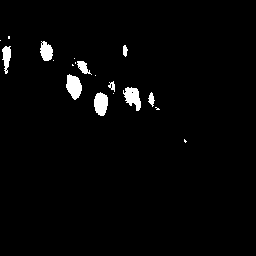 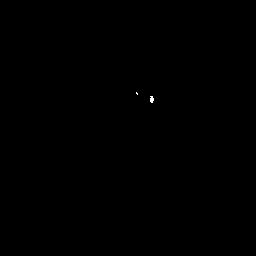 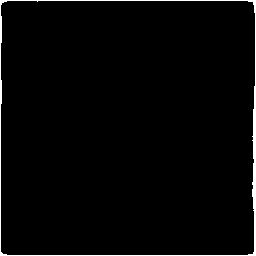

### Nidek-1
The pictures below are for unet model with layers 4, 3, 2 layers respectively. The 2 layer model has very little area highlighted but the layer 3 starts to show more features.

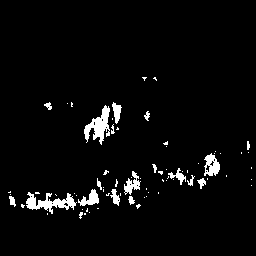 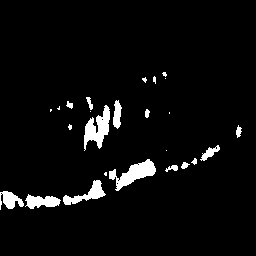 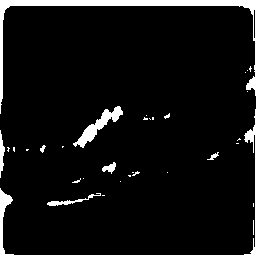